# **7장 – 앙상블 학습과 랜덤 포레스트**

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [ ]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 투표기반 분류기

In [ ]:
# 투표기반 분류기 = 앙상블의 예시
# 분류기를 여러개 적용하면 성능이 좋아진다. 

# 앞면 나올 확률이 0.51인 동전 1000번 던져 앞면이 더 많이 나올 확률
from scipy.stats import binom
a3 = 1-binom.cdf(1,3, 0.51)
print('a3 :', a3)
a10 = 1-binom.cdf(4,10, 0.51)
print('a10 :', a10)
a100 = 1-binom.cdf(49,100, 0.51)
print('a100 :', a100)
a1000 = 1-binom.cdf(499,1000, 0.51)
print('a1000 :', a1000)
a1000_55 = 1-binom.cdf(499,1000, 0.55)
print('a1000_55 :', a1000_55)
a10000 = 1-binom.cdf(4999,10000, 0.51)
print('a10000 :', a10000)

a3 : 0.5149980000000001
a10 : 0.6473972327703659
a100 : 0.6180787124933089
a100_2 : 0.4604607058950889
a1000 : 0.7467502275561786
a1000_55 : 0.9993191913375659
a10000 : 0.9777976478701533


In [ ]:
# 세가지 분류기로 다수결 분류기 만들기.  
# 앙상블,랜덤 포레스트 : 앞에서 배운것들처럼 학습 모델이 아닌, 학습모델을 어떻게 조합하면 성능이 좋아지는지를 알아보는 조합 방법이다.
# 앙상블 : 여러개의 모델을 합한것 -> 여러 모델을 합하면 성능이 좋아짐
# 랜덤 포레스트 : 결정트리의 앙상블로,성능이 아주 뛰어나다. -> 결정트리 모델 여러개를 합한모델임
# 앙상블 방법 -> 다양한 분류기를 학습, 각 분류기 예측 결과를 혼합해서 최종 예측 결과를 결정 -> 따라서 여러 분류기의 예측을 종합해 판단한다. 

# make_moons 데이터 사용
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 분류기 생성
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)


# 하나의 분류기에 Logistic, rf, svc 3개의 분류기를 합해서 넣어준다. ->앙상블하는 방법
# 분류기 모으는 방법 ->
# voting='hard'->클래스(어떤결과나왓는지)이용    vs     voting='soft'->확률이용
# estimator = 앙상블 진행할 모델

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')#클래스 결과만 이용

# 학습, 정확도 계산
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):# 3개를 모은 분류기가 성능 가장 좋다는 것을 알 수 있다.
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)#y_pred -> 출력 결과(클래스)를 가짐
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))# 분류기 이름과 정확도 찍음


LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Soft Voting (간접 투표) : 각 분류기의 클래스 확률을 평균내서 가장 높은 클래스로 분류

In [ ]:
# 각각의 분류기로 학습시킨 결과보다, 3개의 분류기를 합해 학습시킨 정확도가 0.92로 더 좋다. 
# voting soft = 각 분류기의 클래스 확률 이용
# 클래스 확률 이용 -> 이게 더 성능 좋다. 

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)  # SVC는 probability=True로 해야 predict_proba()사용할 수 있음

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')# 클래스 확률 이용 -> 이게 더 성능 좋다. 

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


# 배깅 앙상블

In [ ]:
# 모델이 같아도 다른 학습 데이터 셋을 사용하여 학습하면 다른 분류기(모델)이 만들어짐
# 학습 데이터 셋을 다양하게 해서 여러개의 분류기 만들어 앙상블 진행 -> 분류기 많을수록 성능 좋아짐

# 배깅 앙상블 -> 하나의 분류기에 샘플을 달리해가며 학습시킨다. ->각 샘플별로 다른 분류기가 나옴
# 배깅 : 중복을 허용하는 샘플링 -> 분류기(모델)만들때 샘플을 중복해서 분류기 만듬
# 페이스팅 : 중복을 허용하지 않는 샘플링 -> 샘플을 중복 불가로 해서 분류기 만듬


# decision tree classifier 500개를 배깅 
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# n_estimators :500 -> 500개의 분류기 만들것이다. 
# max_samples :100 -> 무작위로 선택할 샘플 갯수
# bootstrap=true -> 중복허용 -> 배깅

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)# 샘플을 중복해서 분류기 만듬
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)


from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [ ]:
# decision tree classifier 1개만 사용한 경우
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


Text(0, 0.5, '')

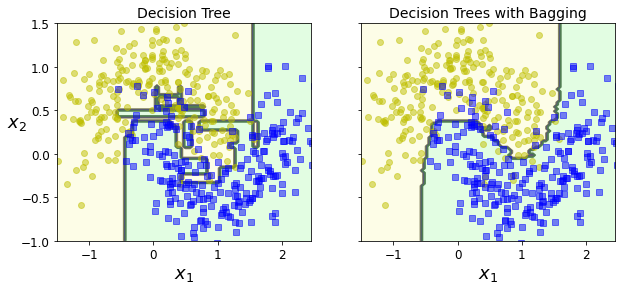

In [ ]:
# 배깅(오른쪽)과 단순 분류기(왼쪽)의 결정경계 시각화
# 왼쪽: 하나의 결정트리,  오른쪽: 여러개의 결정트리 앙상블
# 오른쪽이 복잡도가 낮고, 결정경계가 더 부드럽다(일반화에 좋다.)
# 오른쪽이 학습데이터에 대해 오차는 더 크다., 시간이 더 오래걸린다. 
# 따라서, 앙상블로 복잡도를 줄이고 결정경계를 부드럽게 할 수 있다.

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")


# 랜덤 포레스트

In [ ]:
# 랜덤 -> 무작위로 뽑아서
# 포레스트 -> 숲(결정트리)의 모임
# 따라서 여러개의 결정트리를 모아서 만든것
# 랜덤포레스트 = DecisionTreeClassifier + BaggingClassifier -> 결정트리의 앙상블
# 장점: 특징의 중요도를 알 수 있다. -> 
# 특징으로 분할할 때 지니 불순도를 계산하는데, 그때 그 특징이 불순도를 얼마나 낮추는지를 계산할 수 있다.
# 불순도 많이 낮추는 특징부터 사용


from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)# max_leaf_nodes = 규제
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.912


Text(0.5, 1.0, 'Random Forest')

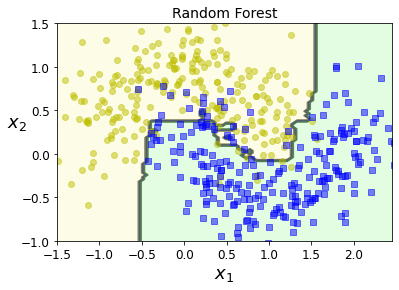

In [ ]:
# 랜덤포리스트로 학습한 결정경계 시각화.  위 Bagging wiht DecisionTree 와 비슷
plot_decision_boundary(rnd_clf, X, y)
plt.title("Random Forest", fontsize=14)

In [ ]:
# 랜덤 포레스트의 장점 -> 특징의 중요도를 알 수 있다.
# 특징 중요도를 알 수 있음 : feature_importances_
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf_iris = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf_iris.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf_iris.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


## OOB 평가

In [ ]:
# 샘플을 무작위로 뽑아서 학습시키기때문에 사용되지 않은 샘플이 있을 수 있다.
# 검증셋(validation set)을 만들 필요가 없음 -> 검증셋의 간단한 버전이 교차검증임
# 사용되지 않은 샘플로 test set 결과 보기전에 간단하게 모델을 평가 할 수있다. -> 편리함
# oob_score=True 주고, 모델.oob_scpre_ 해주면 validation set의 정확도를 알 수 있디.

# BaggingClassifier학습과정에서 out-of-bag 샘플들 평가까지 함
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)# 샘플을 중복해서 분류기 만듬
bag_clf.fit(X_train, y_train)
print('Bagging oob_score_ :', bag_clf.oob_score_)#validation set 으로 평가 가능

# RandomForest도 oob_score 가능
rnd_clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)
rnd_clf.fit(X_train, y_train)
print('RandomForest oob_score_ :', rnd_clf.oob_score_)

Bagging oob_score_ : 0.9013333333333333
RandomForest oob_score_ : 0.904


In [ ]:
# oob 평가는 test샘플 평가와 비슷한 결과 (train샘플에 대한 평가와는 매우 다름)
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
print('test샘플에 대한 정확도 :', accuracy_score(y_test, y_pred))

# 과적합이 된것을 알 수 있다.
y_pred_tra = bag_clf.predict(X_train)
print('train샘플에 대한 정확도 :', accuracy_score(y_train, y_pred_tra))

test샘플에 대한 정확도 : 0.912
train샘플에 대한 정확도 : 1.0


In [ ]:
# oob decision function을 알 수도 있음
bag_clf.oob_decision_function_[:5]

array([[0.31746032, 0.68253968],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## MNIST 데이터 특성 중요도 시각화

In [ ]:
# MNIST 데이터 학습
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)#학습
rnd_clf.fit(mnist["data"], mnist["target"])


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

[Text(1, 0, 'Not important'), Text(1, 0, 'Very important')]

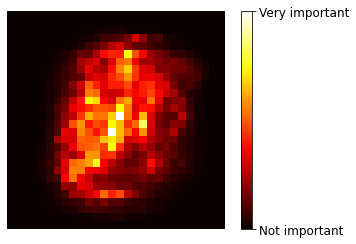

In [ ]:
# 특징의 중요도를 보여줌
# 힌색에 가까울수록 좋은 특징 
# 검은색 특징은 별로 중요하지 않은것임
# 

# 시각화
import matplotlib as mpl
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)# 중요도를 출력

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
  

# 에이다부스트

In [ ]:
# 부스팅 : 약한 학습기를 여러개 연결해서 강한 학습기를 만드는 앙상블 방법
# 앞 모델을 보완해 나가도록 모델을 학습하여 연결해 나감 -> 직렬화
# 앞의 배깅은 병렬화임
# 부스팅 종류 ; 1. 에이다부스트, 2. 그레디언트부스트
# 따라서 부스팅은 모델을 먼저 학습시키고, 그 모델을 보완해 나가며 모델의 성능을 높이는 방법이다. 

# 에이다 부스트 : 샘플에 가중치를 부여해 오차가 큰 샘플에 더 큰 가중치를 준다.

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(# 에이다부스트 모델 만들기 
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred_tra = ada_clf.predict(X_train)
y_pred = ada_clf.predict(X_test)
print('n_estimators=200. training샘플 정확도 :', accuracy_score(y_train, y_pred_tra), ', test샘플 정확도 :', accuracy_score(y_test, y_pred))

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)
y_pred_tra = ada_clf.predict(X_train)
y_pred = ada_clf.predict(X_test)
print('n_estimaors=100. training샘플 정확도 :', accuracy_score(y_train, y_pred_tra), ', test샘플 정확도 :', accuracy_score(y_test, y_pred))

n_estimators=200. training샘플 정확도 : 0.968 , test샘플 정확도 : 0.896
n_estimaors=100. training샘플 정확도 : 0.96 , test샘플 정확도 : 0.912


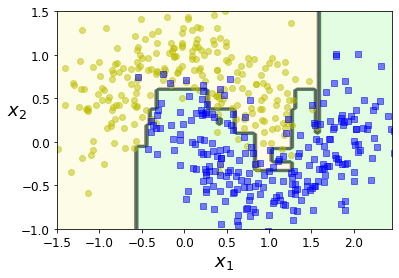

In [ ]:
plot_decision_boundary(ada_clf, X, y)

# 그레이디언트 부스팅

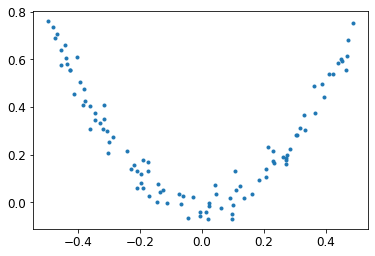

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

plt.plot(X, y, '.')

In [ ]:
#그레디언트 부스팅 : 에이다부스트와 동일하게 이전의 모델을 보정해가며 성능을 높인다.
# 다른점은 잔여오차에 새로운 예측기로 학습시킨다. -> 오차에 대해서만 학습
# 

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
y2 = y - tree_reg1.predict(X) # 차이값을 학습시킨다. 
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Text(0, 0.5, '$y$')

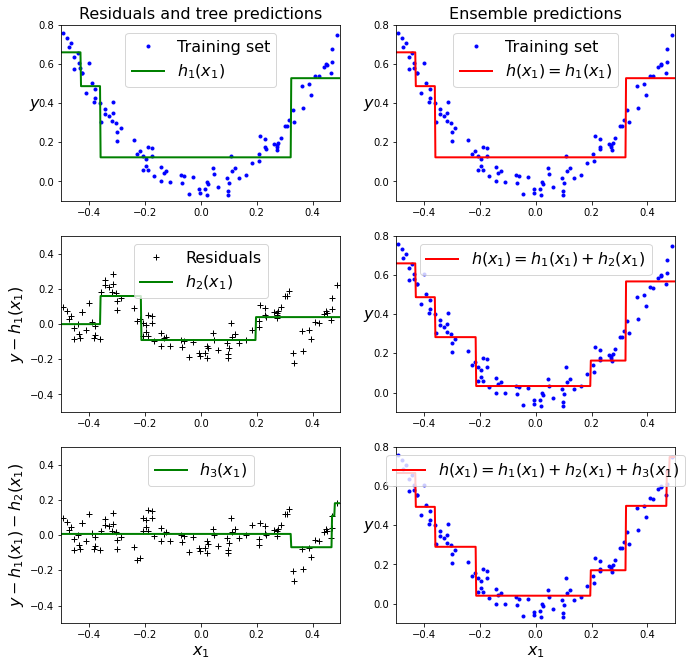

In [ ]:
# 오차에 대해서만 학습시킴

plt.figure(figsize=(11,11))

plt.subplot(321)#첫번째 왼쪽 그래프 -> 첫번째 모델
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)#첫번째 오른쪽 그래프
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)# 두번째 왼쪽 그래프 -> 2번째 모댈
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)# 두번째 오른쪽 그래프 -> 첫번째 모델과 두번째 모델 합친거
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)



In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1.0, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Text(0.5, 0, '$x_1$')

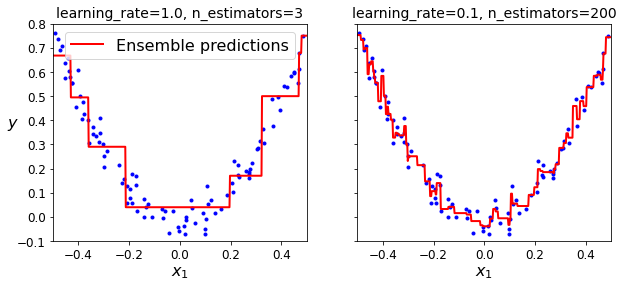

In [ ]:
# 왼쪽 : 모델 3개짜리
# 오른쪽 : 모델 200개 짜리 
# 모델 갯수 늘리면 일반화에 안좋아짐 -> 복잡해져서 과대적합 되기 때문에 


fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)


## 조기 종료를 사용한 그래디언트 부스팅

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# staged_predict -> 하나하나씩 증가하면서 오차 비교해줌
# bst_n_estimators : 가장 적합한 트리 숫자
errors = [mean_squared_error(y_val, y_pred)# 최적의 트리 숫자 찾아줌
          for y_pred in gbrt.staged_predict(X_val)]  # staged_predict() : 각 단계별 predict() 
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=56,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
min_error = np.min(errors)

Text(0.5, 0, '$x_1$')

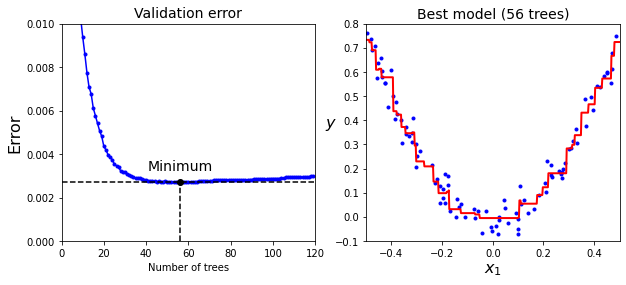

In [ ]:
# 조기종료 이용해서 과적합 피할 수 있다.

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)


In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

#위의 과정을 아래와 같이 쉽게 구현할 수 있다. -> 끝까지 가지 않고 증가할때 종료
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:# 5회동안 증가하면 끝냄
            break  # early stopping

In [ ]:
print(gbrt.n_estimators)

61


In [ ]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


# <font color=red> 과제 </font>
실습 과제 없습니다.  기말 프로젝트 발표준비 잘 하기 바랍니다.